# 0. Import Library

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

/var/folders/hv/11wz_8q5047615xw8tzd_bpw0000gn/T/ipykernel_5733/3067738315.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000 # number of words in the vocab

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorized_text = vectorizer(X.values)

In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [13]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [16]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 2385s 341ms/step - loss: 0.0632 - val_loss: 0.0466


In [17]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

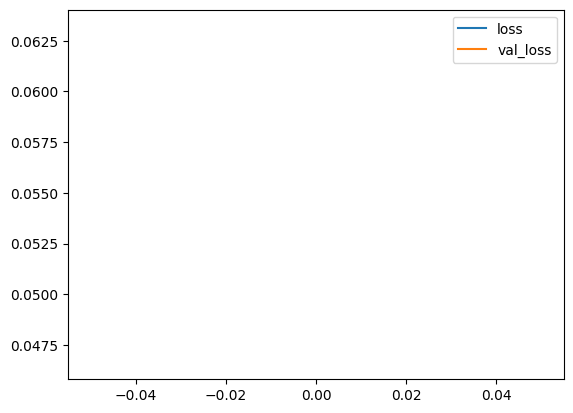

In [18]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [19]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [20]:
batch = test.as_numpy_iterator().next()

In [21]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [22]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 349ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [23]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 40ms/step


In [36]:
# res = model.predict(input_text)

In [24]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [25]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [26]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 51ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [27]:
res.shape

(1, 6)

# 4. Evaluate Model

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 46ms/step


In [31]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8216198086738586, Recall:0.6766813397407532, Accuracy:0.48345035314559937


In [32]:
# Lưu mô hình
model.save('trained_model.h5')

# Tải lại mô hình
loaded_model = tf.keras.models.load_model('trained_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
from flask import Flask, request, jsonify
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization


app = Flask(__name__)

# Load the vectorizer
MAX_FEATURES = 200000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)

# Load the model
model = tf.keras.models.load_model('trained_model.h5')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    comment = data['comment']
    
    # Vectorize the comment
    vectorized_comment = vectorizer([comment])
    
    # Make prediction
    prediction = model.predict(vectorized_comment)

    # Adjust the response based on your model output
    result = {
        'toxic': bool(prediction[0][0] > 0.5),  # Convert to boolean
        'other_labels': prediction[0][1:].tolist()
    }

    return jsonify(result)

if __name__ == '__main__':
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


1/1 [==============================] - 0s 273ms/step


127.0.0.1 - - [15/Feb/2024 23:48:05] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [15/Feb/2024 23:48:10] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [15/Feb/2024 23:48:15] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [15/Feb/2024 23:48:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [15/Feb/2024 23:48:21] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [15/Feb/2024 23:48:38] "POST /predict HTTP/1.1" 200 -


In [33]:
from flask import Flask, request, jsonify

In [34]:
app = Flask(__name__)

In [35]:
@app.route('/predict', methods=['POST'])
# def predict():
#     data = request.get_json(force=True)
#     comment = data['comment']
    
#     # Vectorize the comment
#     vectorized_comment = vectorizer([comment])
    
#     # Make prediction
#     prediction = model.predict(vectorized_comment)

#     # Adjust the response based on your model output
#     result = {
#         'toxic': prediction[0][0] > 0.5,
#         'other_labels': prediction[0][1:].tolist()
#     }

#     return jsonify(result)
def predict():
    data = request.get_json(force=True)
    comment = data['comment']
    
    # Vectorize the comment
    vectorized_comment = vectorizer([comment])
    
    # Make prediction
    prediction = model.predict(vectorized_comment)

    # Adjust the response based on your model output
    result = {
        'toxic': bool(prediction[0][0] > 0.5),  # Convert to boolean
        'other_labels': prediction[0][1:].tolist()
    }

    return jsonify(result)

if __name__ == '__main__':
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Feb/2024 00:05:23] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [11/Feb/2024 00:05:24] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [11/Feb/2024 00:05:24] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [11/Feb/2024 00:05:26] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [11/Feb/2024 00:05:26] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [11/Feb/2024 00:05:26] "POST /predict HTTP/1.1" 400 -


1/1 [==============================] - 0s 104ms/step


127.0.0.1 - - [11/Feb/2024 00:07:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 00:07:23] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:07:39] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:07:40] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:07:40] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:07:41] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:07:41] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:07:41] "OPTIONS /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 00:17:11] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:27:56] "OPTIONS /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 100ms/step


127.0.0.1 - - [11/Feb/2024 00:31:40] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:36:17] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:36:21] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:45:32] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 00:45:33] "OPTIONS /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 91ms/step


127.0.0.1 - - [11/Feb/2024 00:51:43] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 00:51:53] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [11/Feb/2024 00:51:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 00:52:12] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 00:53:42] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 00:53:48] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 00:53:54] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 00:54:34] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [11/Feb/2024 00:54:40] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [11/Feb/2024 00:55:07] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 00:55:39] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 33ms/step


127.0.0.1 - - [11/Feb/2024 00:55:55] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 00:58:09] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 00:58:22] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:08:32] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:08:33] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:08:33] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:08:35] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:08:35] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:08:35] "OPTIONS /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 01:09:05] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 01:09:09] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 01:13:45] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 01:13:50] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 01:15:01] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 88ms/step


127.0.0.1 - - [11/Feb/2024 01:15:50] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 01:18:37] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 01:18:56] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 01:19:00] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [11/Feb/2024 01:21:21] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 01:22:43] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 01:22:46] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 34ms/step


127.0.0.1 - - [11/Feb/2024 01:22:55] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 01:22:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 01:24:54] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 102ms/step


127.0.0.1 - - [11/Feb/2024 01:28:09] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 01:28:30] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 01:32:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 34ms/step


127.0.0.1 - - [11/Feb/2024 01:33:03] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [11/Feb/2024 01:34:30] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 01:34:41] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [11/Feb/2024 01:38:11] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:38:28] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:38:35] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [11/Feb/2024 01:39:33] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:39:41] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:39:45] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:39:47] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [11/Feb/2024 01:40:07] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:40:15] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:40:17] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 33ms/step


127.0.0.1 - - [11/Feb/2024 01:40:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:40:24] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 33ms/step


127.0.0.1 - - [11/Feb/2024 01:40:25] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:40:50] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:41:23] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:21] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:26] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:27] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:29] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:30] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:31] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:42:57] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:43:03] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:43:07] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:43:08] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:43:09] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:43:10] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 32ms/step


127.0.0.1 - - [11/Feb/2024 01:43:11] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:46:28] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:46:28] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:46:28] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [11/Feb/2024 01:46:28] "OPTIONS /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 106ms/step


127.0.0.1 - - [11/Feb/2024 01:50:41] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 45ms/step


127.0.0.1 - - [11/Feb/2024 01:50:46] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 01:50:52] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 85ms/step


127.0.0.1 - - [11/Feb/2024 01:59:25] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [11/Feb/2024 01:59:49] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 02:02:44] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 02:04:02] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 02:04:13] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 02:09:47] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 02:10:05] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 44ms/step


127.0.0.1 - - [11/Feb/2024 02:10:11] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 02:10:21] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 02:14:42] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 02:15:03] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 02:15:57] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 02:16:12] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 02:18:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 02:19:10] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [11/Feb/2024 02:19:28] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 02:19:33] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 02:19:39] "POST /predict HTTP/1.1" 200 -
[2024-02-11 02:24:15,675] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/flask/app.py", line 1463, in wsgi_app
    response = self.full_dispatch_request()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/flask/app.py", line 872, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/flask/app.py", line 870, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/flask/app.py", line 855, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
  File "/var/folders/hv/11wz_8q5047615xw8tzd_bpw0000gn/T/ipykernel_35

1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 02:36:54] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 02:36:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 92ms/step


127.0.0.1 - - [11/Feb/2024 02:46:33] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 02:47:43] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 02:48:49] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 44ms/step


127.0.0.1 - - [11/Feb/2024 02:49:14] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 02:50:26] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 02:50:32] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 57ms/step


127.0.0.1 - - [11/Feb/2024 02:51:39] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 02:51:55] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 02:52:24] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 44ms/step


127.0.0.1 - - [11/Feb/2024 02:52:52] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 02:52:57] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 02:53:07] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 114ms/step


127.0.0.1 - - [11/Feb/2024 02:56:52] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 45ms/step


127.0.0.1 - - [11/Feb/2024 02:57:41] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 02:58:04] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 02:58:18] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:00:06] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:01:01] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 103ms/step


127.0.0.1 - - [11/Feb/2024 03:04:17] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:04:43] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 44ms/step


127.0.0.1 - - [11/Feb/2024 03:05:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 03:06:36] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:07:25] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:07:38] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 03:08:07] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 03:08:18] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 03:08:23] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 52ms/step


127.0.0.1 - - [11/Feb/2024 03:08:30] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:08:37] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:08:55] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:09:15] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:09:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 03:09:32] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 44ms/step


127.0.0.1 - - [11/Feb/2024 03:09:38] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 03:10:23] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 03:10:29] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:11:22] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:12:40] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 03:12:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:13:10] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [11/Feb/2024 03:13:25] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:14:27] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:14:46] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:15:03] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:15:24] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 03:15:41] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 03:17:53] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:18:04] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:18:13] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:18:28] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 42ms/step


127.0.0.1 - - [11/Feb/2024 03:18:31] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 03:18:48] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:19:02] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:19:52] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [11/Feb/2024 03:20:05] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:20:59] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 03:21:31] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 37ms/step


127.0.0.1 - - [11/Feb/2024 03:22:37] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:22:49] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 03:23:16] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:23:21] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 40ms/step


127.0.0.1 - - [11/Feb/2024 03:23:34] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 38ms/step


127.0.0.1 - - [11/Feb/2024 03:23:57] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 41ms/step


127.0.0.1 - - [11/Feb/2024 03:34:52] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 39ms/step


127.0.0.1 - - [11/Feb/2024 03:38:39] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 65ms/step


127.0.0.1 - - [11/Feb/2024 03:50:16] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 99ms/step


127.0.0.1 - - [11/Feb/2024 04:13:16] "POST /predict HTTP/1.1" 200 -


# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [21]:
model.save('toxicity.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
